In [1]:
import parallelPermutationTest as ppt
import numpy as np
import pandas as pd
import time

from scipy.stats import ttest_ind, mannwhitneyu
from plots import SNSMultipleboxPlot, log_vs_log_plot

In [2]:
%load_ext cython
%load_ext rpy2.ipython



In [3]:
%%capture
%%R

require(ggplot2)
install.packages("devtools")
library("devtools")
install_github("bdsegal/fastPerm")

library(fastPerm)

In [4]:
%%R
    runFastPerm <- function(x,y,output, n_samples) {
        e <- list(mode="vector",length=n_samples)
        for (i in 1:n_samples) {
      
            mStopDiffMean(x[[i]], y[[i]])
            valX = fastPerm(x[[i]], y[[i]], testStat = diffMean)
            
            valX <-unlist(valX)

      
            output[[i]] <- as.numeric(valX[1])
      
            }
    

    return(output)


    }

In [5]:
def fastPerm(A,B):
    x = pd.DataFrame(A, columns=list(range(A.shape[1]))).T
    y = pd.DataFrame(B, columns=list(range(B.shape[1]))).T
    n_samples = x.shape[1]
    outputDf = pd.DataFrame(n_samples * [0], columns=["output"]).T
    
    %R -i x
    %R -i y
    %R -i outputDf
    %R -i n_samples
    
    
    %R out <- runFastPerm(x,y, outputDf, n_samples)
    
    
    %R -o out
    return list(out.T["output"].values)

In [6]:
class accuracy_experiment:
    
    def MWU(self, A, B, one_side=False):
        p_mw = list()
        for a,b in zip(A, B):
            if one_side:
                p_mw.append(mannwhitneyu(a,b, alternative="less")[1])
            else:
                p_mw.append(mannwhitneyu(a,b, alternative="two-sided")[1])
        return p_mw

    def ttests(self, A, B, one_side=False):
        p_t = list()
        for x, y in zip(A, B):
            t, p = ttest_ind(y, x)
            if one_side:
                p = p/2
                if t<0:
                    p = 1-p
            p_t.append(p)
        return p_t

    def getErrors(self, pValList, pTtestList, rel=True):
        def relError(x, y):
            return frac((x - y), y) 

        def frac(x, y):
            return x / y
    
        relatvieErrorList = list()
        for pv, pt in zip(pValList, pTtestList):
            if rel:
                relatvieErrorList.append(relError(pv, pt))
            else:
                relatvieErrorList.append(frac(pv, pt))
            
        return relatvieErrorList

    def getSynteticData(self, func, setN=20, sampleN=2_000, mean=0, std=1,seed=1):
        """Generate synthetic data"""
        np.random.seed(seed)
        AN, BN = [func(mean,std,setN) for i in range(sampleN)], [func(0,std,setN) for i in range(sampleN)]
        return AN, BN
    
    def getPvalues(self, setSize, mean=0.2, return_pvalues=False, S=50):
        allFracList1 = list()
        allFracMWUList1 = list()
        allFracFPList1 = list()
        
        allPvalTtestList = list()
        allPvalMWUList = list()
        allPvalFastPermList = list()
        allPvalExactList = list()
        
        for setS in setSize:
            Anorm0, Bnorm0 = self.getSynteticData(np.random.normal, mean=mean, setN=setS,sampleN=S)
            ptTest  = self.ttests(Anorm0, Bnorm0)
            
            allPvalTtestList.append(ptTest)
    
            peList = ppt.GreenFloatCuda(np.array(Anorm0), np.array(Bnorm0), 100, batch_size= int(np.array(Anorm0).shape[0] / 2))
            ExactFracList = self.getErrors(peList, ptTest, False) 
            allFracList1.append(ExactFracList)
            
            allPvalExactList.append(peList)
    
            pmwList = self.MWU(Anorm0, Bnorm0)
            MWUFracList = self.getErrors(pmwList, ptTest, False) 
            allFracMWUList1.append(MWUFracList)
            
            allPvalMWUList.append(pmwList)
    

            ptfp = fastPerm(np.array(Anorm0), np.array(Bnorm0))
            FPFracList = self.getErrors(ptfp, ptTest, False)
            allFracFPList1.append(FPFracList)
            
            allPvalFastPermList.append(ptfp)
            
        if return_pvalues:
            return allPvalTtestList, allPvalMWUList, allPvalFastPermList, allPvalExactList
        else:
            return allFracList1, allFracMWUList1, allFracFPList1

    def getNwPlot(self, setSize, mean=0.1):
        N_w = list(range(5, 105,5))
        allEerrorNw, allEerrorNwFrac = list(), list()
        for n_w in N_w:
            Anorm0, Bnorm0 = self.getSynteticData(np.random.normal, mean=mean, setN=setSize,sampleN=50)
            ptTest  = self.ttests(Anorm0, Bnorm0)
    
            peList = ppt.GreenFloatCuda(np.array(Anorm0), np.array(Bnorm0), n_w)
            ExactErrorList = self.getErrors(peList, ptTest)
            ExactFracList = self.getErrors(peList, ptTest, False) 
            allEerrorNw.append(np.abs(ExactErrorList))
            allEerrorNwFrac.append(ExactFracList)
        return allEerrorNwFrac, N_w
    
    


In [7]:
exp = accuracy_experiment()

In [8]:
setSize = [10,50,100,150,200,250,300]


In [9]:
allFracList1, allFracMWUList1, allFracFPList1 = exp.getPvalues(setSize)

In [10]:
Names = ["Green", "Mann–Whitney $\it{U}$ test", "FastPerm"]
data = [allFracList1, allFracMWUList1, allFracFPList1]

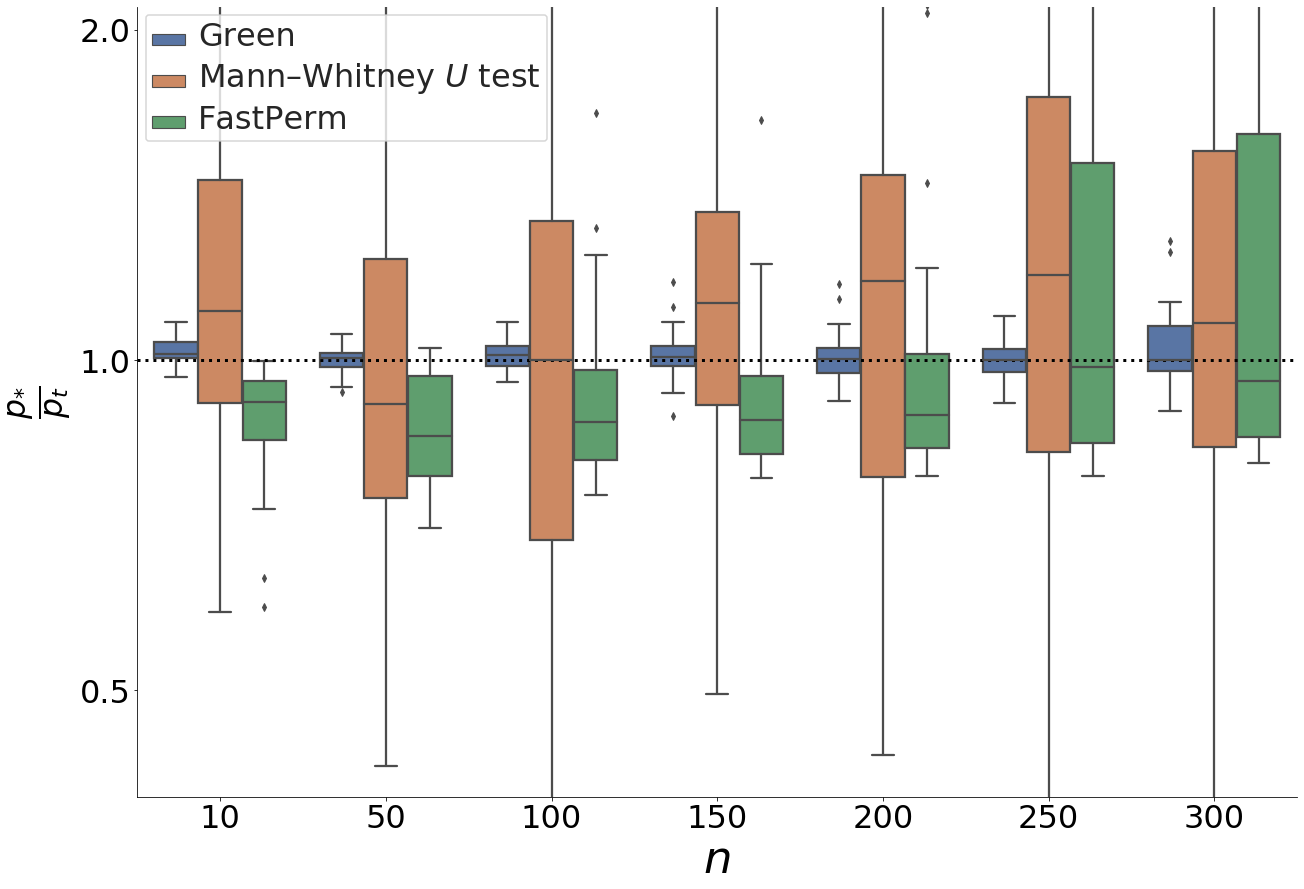

In [11]:
SNSMultipleboxPlot(data, Names, setSize,
                   relError=False,
                   path="./figures/experiment7/all_model_error_02",
                  dashed=True,ylim=[0.4, 2.1])

In [12]:
allFracList2, allFracMWUList2, allFracFPList2 = exp.getPvalues(setSize, 1)

In [13]:
data2 = [allFracList2, allFracMWUList2, allFracFPList2]

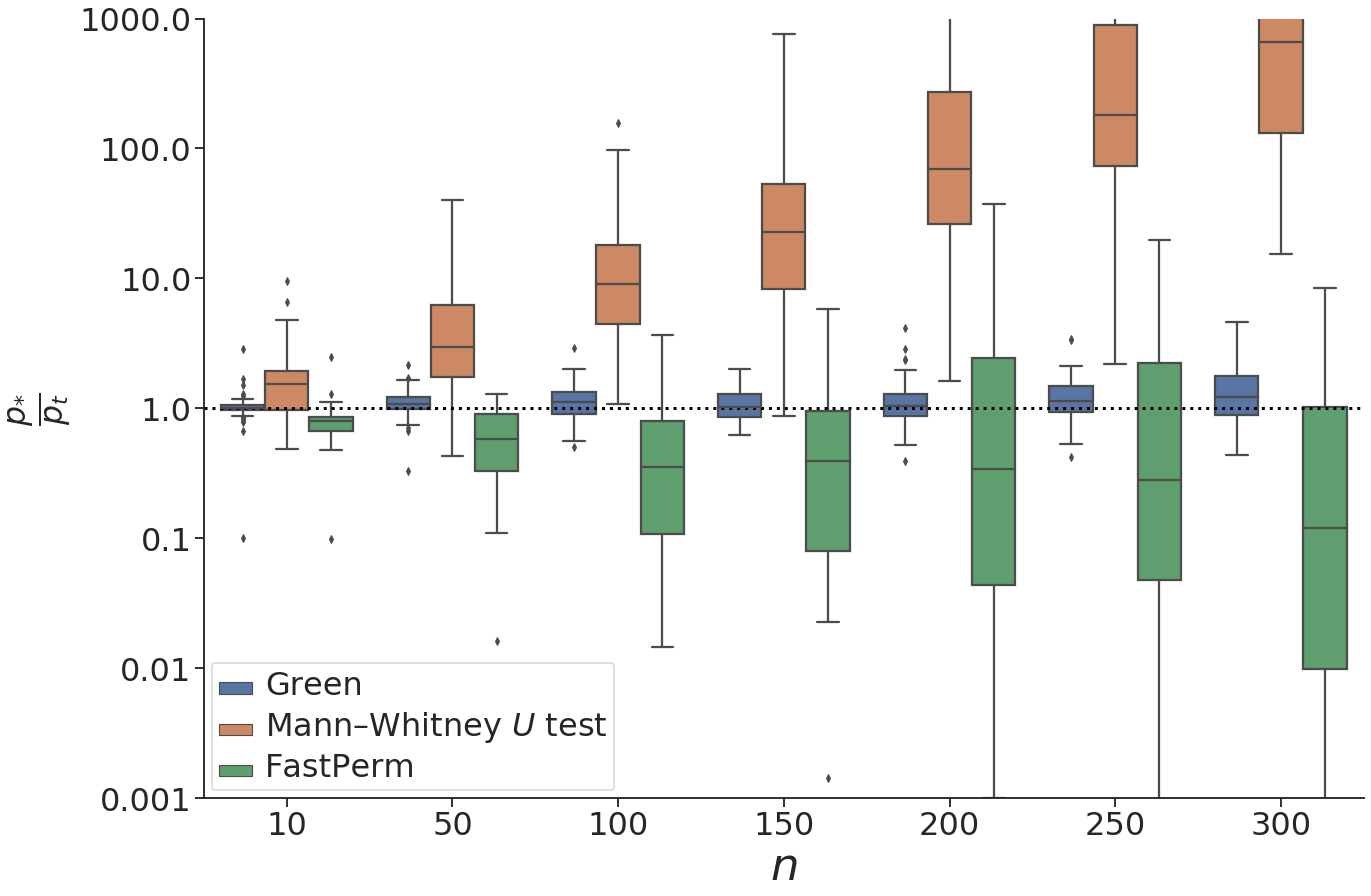

In [14]:
SNSMultipleboxPlot(data2, Names, setSize, relError=False,
                   path="./figures/experiment7/all_model_error_1",
                   dashed=True, ylim=[10**-3, 10**3])



# |A|=|B|=150 $\mu = 1$

In [15]:
n3 = setSize[3]; n3

150

In [16]:
allEerrorNwFrac3_m_1, N_w = exp.getNwPlot(n3, 1)



In [17]:
N_w

[5,
 10,
 15,
 20,
 25,
 30,
 35,
 40,
 45,
 50,
 55,
 60,
 65,
 70,
 75,
 80,
 85,
 90,
 95,
 100]

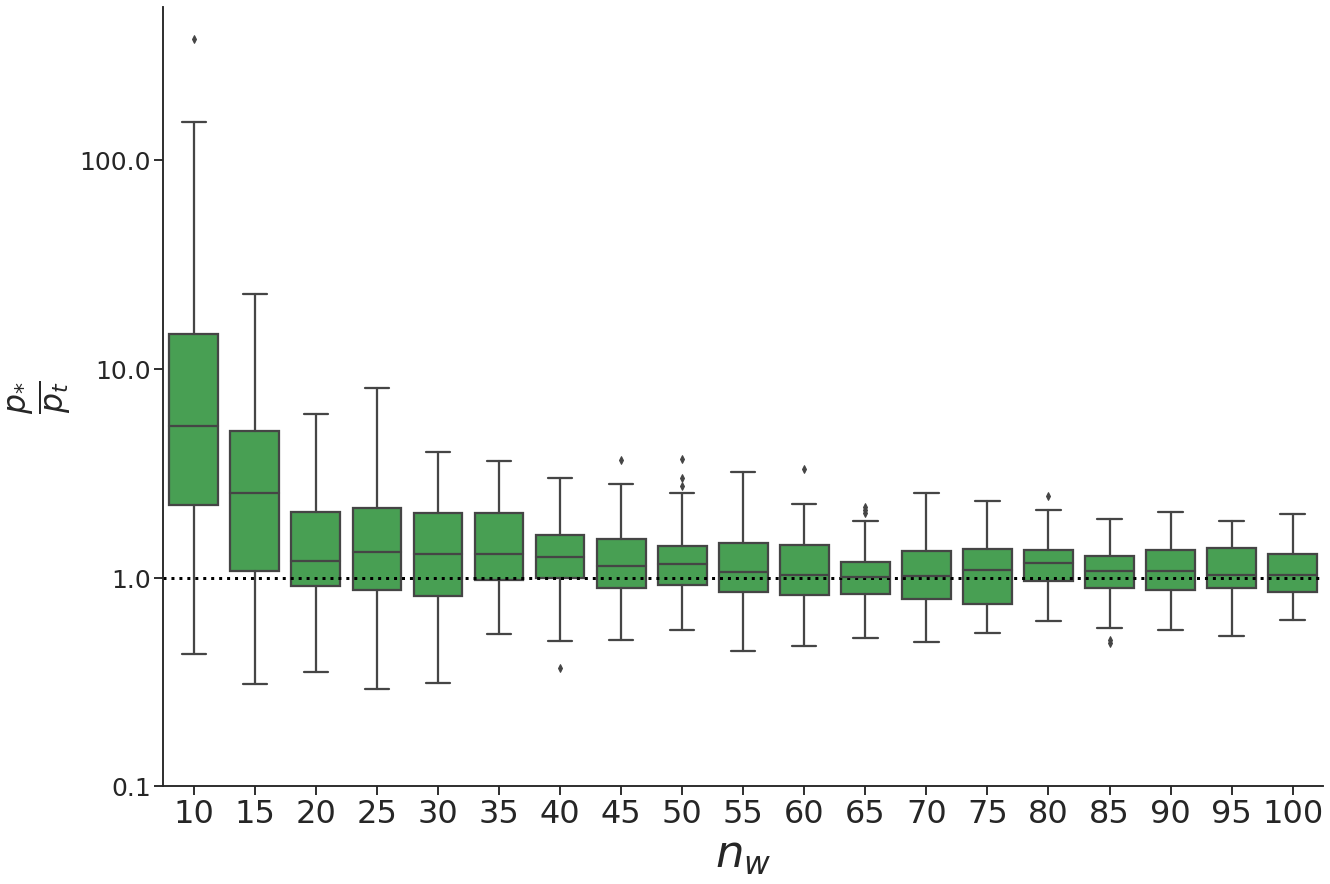

In [18]:
SNSMultipleboxPlot([allEerrorNwFrac3_m_1[1:]],["x"], N_w[1:], test_type="windowSize", 
                   relError=False,
                   path="./figures/experiment7/parallel_green_1_" + str(n3),
                  dashed=True)

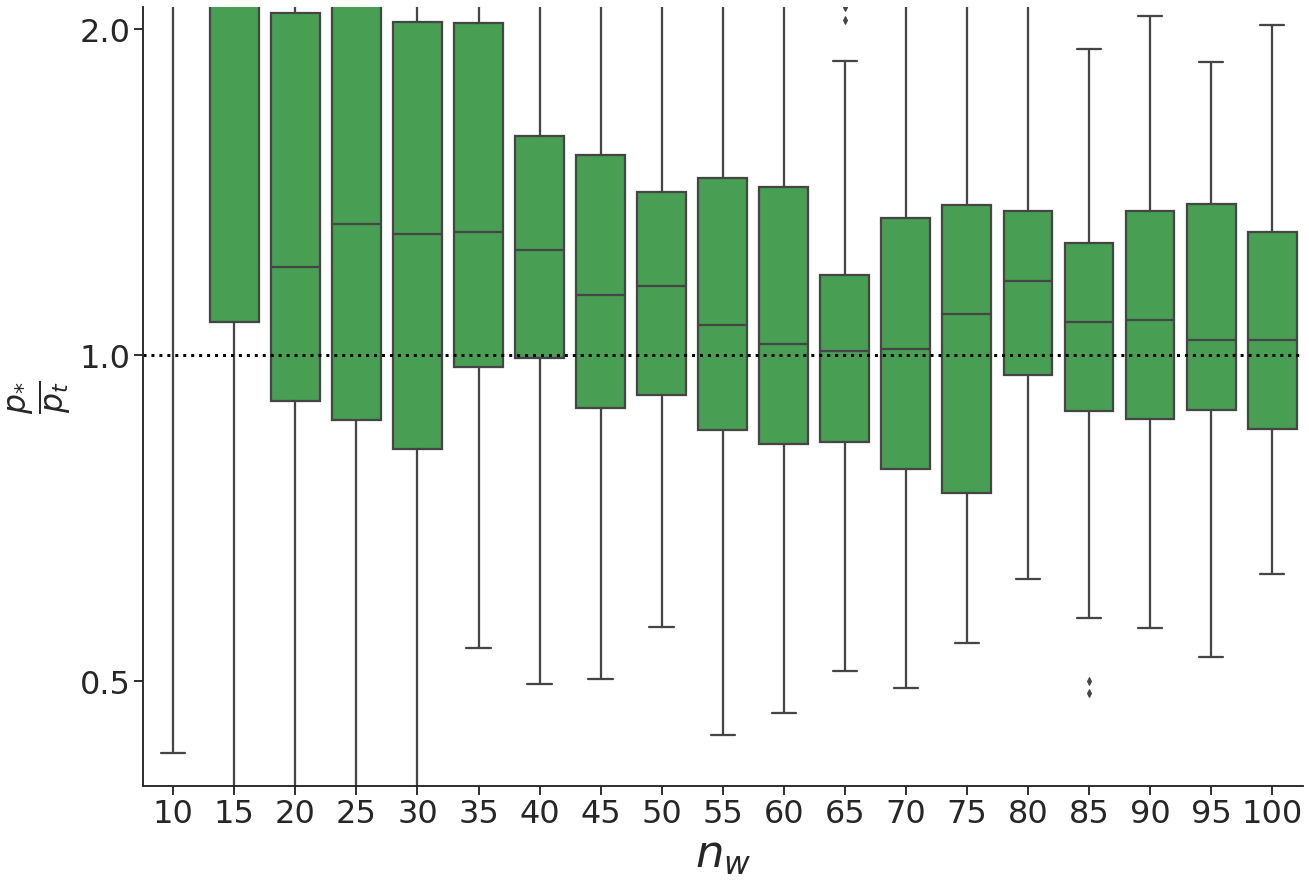

In [19]:
SNSMultipleboxPlot([allEerrorNwFrac3_m_1[1:]],["x"], N_w[1:], test_type="windowSize", 
                   relError=False,
                   path="./figures/experiment7/parallel_green_1_" + str(n3),
                  dashed=True,
                  ylim=[0.4, 2.1])

# |A|=|B|=150 $\mu = 0.2$

In [20]:
allEerrorNwFrac3_m_02, N_w = exp.getNwPlot(n3, 0.2)



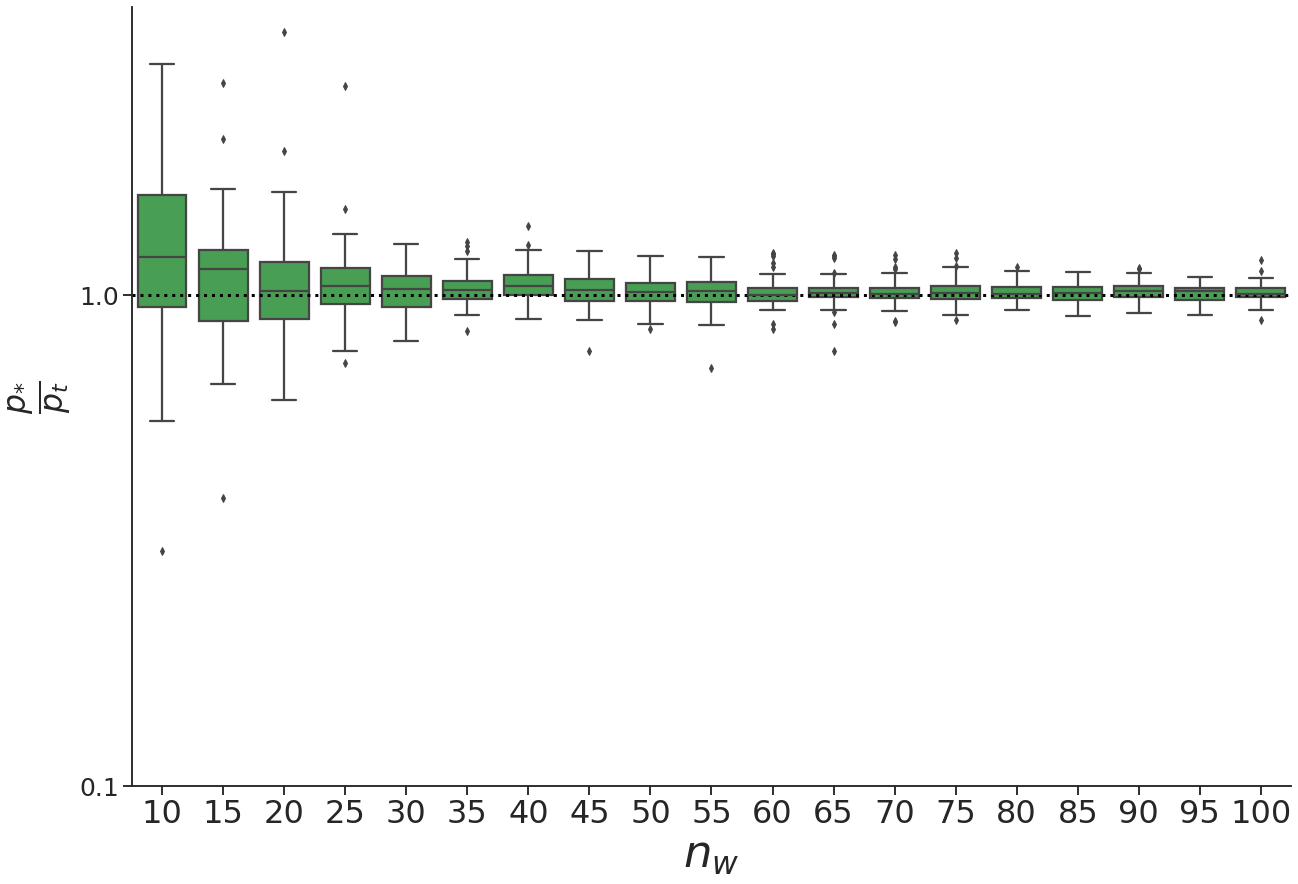

In [21]:
SNSMultipleboxPlot([allEerrorNwFrac3_m_02[1:]],["x"], N_w[1:], test_type="windowSize", 
                   relError=False,
                   path="./figures/experiment7/parallel_green_02_" + str(n3),
                  dashed=True)

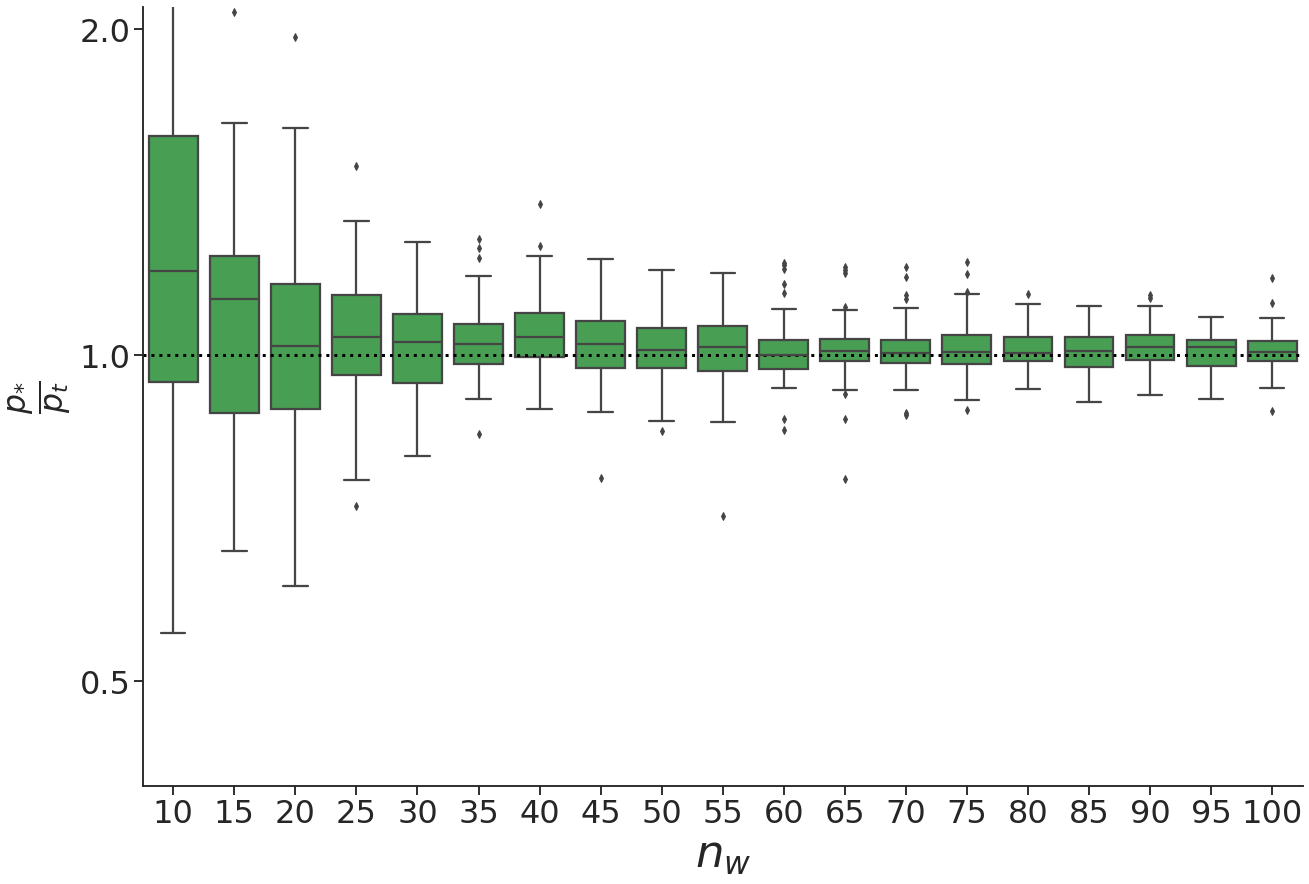

In [22]:
SNSMultipleboxPlot([allEerrorNwFrac3_m_02[1:]],["x"], N_w[1:], test_type="windowSize", 
                   relError=False,
                   path="./figures/experiment7/parallel_green_02_" + str(n3),
                  dashed=True,ylim=[0.4, 2.1])


In [23]:
setSize = [100]

In [24]:
allPvalTtestList, allPvalMWUList, allPvalFastPermList, allPvalExactList = exp.getPvalues(setSize, 1, True, 1_000)

In [25]:
getNegLog = lambda A : -1 * np.log10(np.array(A[0]))

In [26]:
Data = [getNegLog(allPvalMWUList), getNegLog(allPvalFastPermList), getNegLog(allPvalExactList)]
y_data = getNegLog(allPvalTtestList)

In [27]:
names = ["Mann–Whitney $\it{U}$ test", "FastPerm", "Green"]

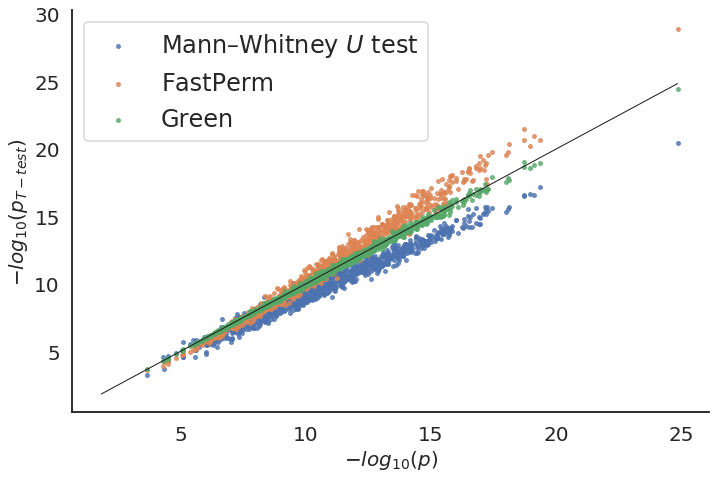

In [28]:
log_vs_log_plot(Data, names, y_data, "$-log_{10}(p_{T-test}$)" , "$-log_{10}(p)$",log=False, path="./figures/experiment7/logpt_logp_plot")